In [49]:
#!/usr/bin/env python
# coding: utf-8

# # BigMart Sales Prediction - End-to-End Solution
# 
# The goal of this project is to predict sales for products across different outlets of BigMart. I'll tackle this through several steps:
# 
# 1. Data understanding & exploration
# 2. Data cleaning & preprocessing
# 3. Feature engineering
# 4. Building predictive models
# 5. Generating submission file

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import gc

# For modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

# For deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For advanced gradient boosting
import lightgbm as lgb
import xgboost as xgb

# Configure visualizations and suppress warnings
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid")

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [50]:
# # 1. Data Loading and Understanding

print("Loading data...")
train = pd.read_csv('/kaggle/input/big-mart-sales-prediction-datasets/train.csv')
test = pd.read_csv('/kaggle/input/big-mart-sales-prediction-datasets/test.csv')

# Mark datasets with source for later separation
train['source'] = 'train'
test['source'] = 'test'

Loading data...


In [51]:
# Combine for consistent preprocessing
data = pd.concat([train, test], ignore_index=True)

print(f"Train shape: {train.shape}, Test shape: {test.shape}")
print(f"Combined data shape: {data.shape}")

# Let's check the basic info of our dataset
print("\nOverview of the dataset:")
data.info()

# Let's see a sample of the data
print("\nSample data:")
data.head()

Train shape: (8523, 13), Test shape: (5681, 12)
Combined data shape: (14204, 13)

Overview of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14204 entries, 0 to 14203
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14204 non-null  object 
 1   Item_Weight                11765 non-null  float64
 2   Item_Fat_Content           14204 non-null  object 
 3   Item_Visibility            14204 non-null  float64
 4   Item_Type                  14204 non-null  object 
 5   Item_MRP                   14204 non-null  float64
 6   Outlet_Identifier          14204 non-null  object 
 7   Outlet_Establishment_Year  14204 non-null  int64  
 8   Outlet_Size                10188 non-null  object 
 9   Outlet_Location_Type       14204 non-null  object 
 10  Outlet_Type                14204 non-null  object 
 11  Item_Outlet_Sales          8523 non-null   float64


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [52]:
# Check for missing values
print("\nMissing values in each column:")
missing_values = data.isnull().sum()
missing_percent = (missing_values / len(data)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 
                         'Percentage': missing_percent.round(2)})
print(missing_df[missing_df['Missing Values'] > 0])


Missing values in each column:
                   Missing Values  Percentage
Item_Weight                  2439       17.17
Outlet_Size                  4016       28.27
Item_Outlet_Sales            5681       40.00


In [53]:
# # 2. Exploratory Data Analysis (EDA)

print("\nBasic statistics for numerical columns:")
print(data.describe())

# Let's check unique values for each categorical variable
print("\nUnique values in categorical columns:")
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col not in ['Item_Identifier', 'Outlet_Identifier', 'source']:
        print(f"\n{col} - {data[col].nunique()} unique values:")
        print(data[col].value_counts())


Basic statistics for numerical columns:
        Item_Weight  Item_Visibility      Item_MRP  Outlet_Establishment_Year  \
count  11765.000000     14204.000000  14204.000000               14204.000000   
mean      12.792854         0.065953    141.004977                1997.830681   
std        4.652502         0.051459     62.086938                   8.371664   
min        4.555000         0.000000     31.290000                1985.000000   
25%        8.710000         0.027036     94.012000                1987.000000   
50%       12.600000         0.054021    142.247000                1999.000000   
75%       16.750000         0.094037    185.855600                2004.000000   
max       21.350000         0.328391    266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         1

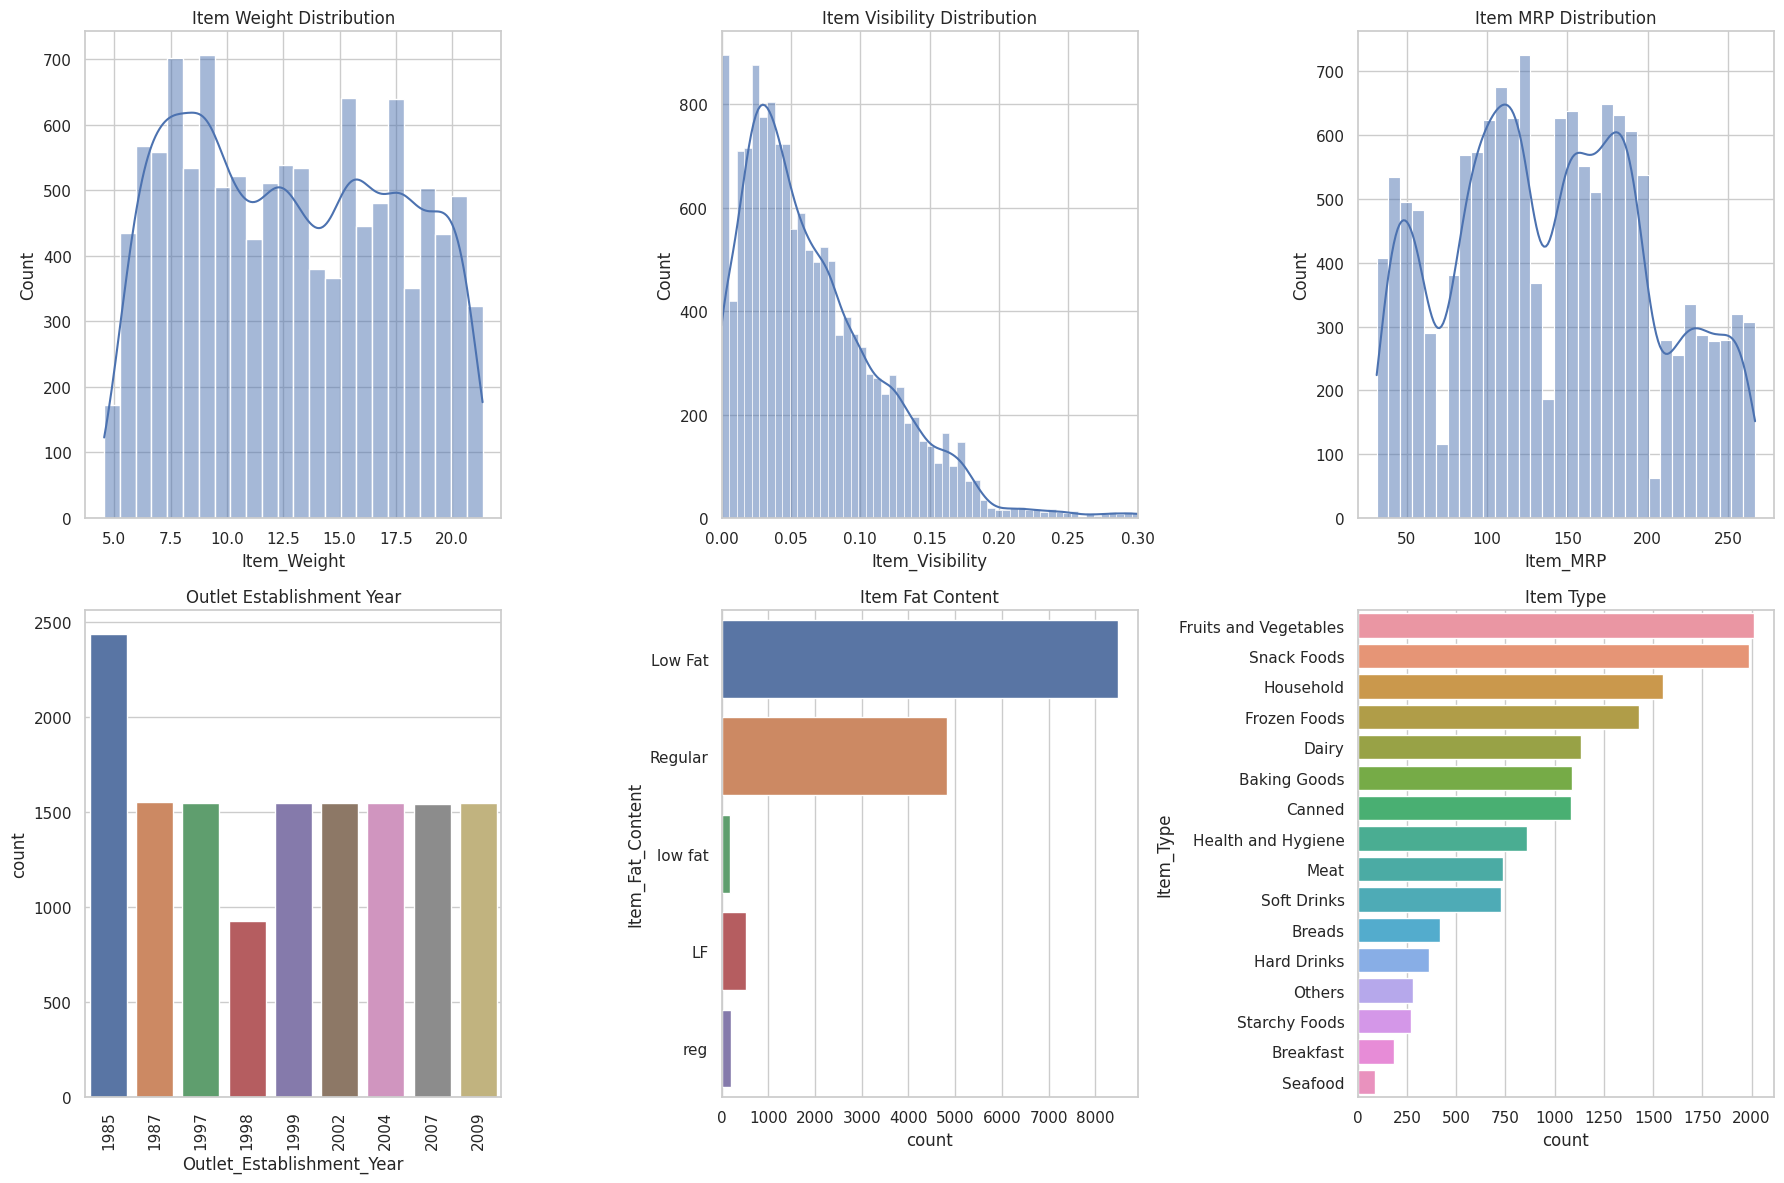

In [54]:
# Let's visualize distributions of some key features
plt.figure(figsize=(18, 12))

# Item_Weight distribution
plt.subplot(2, 3, 1)
sns.histplot(data['Item_Weight'].dropna(), kde=True)
plt.title('Item Weight Distribution')

# Item_Visibility distribution
plt.subplot(2, 3, 2)
sns.histplot(data['Item_Visibility'], kde=True)
plt.title('Item Visibility Distribution')
plt.xlim(0, 0.3)  # Focusing on the main distribution range

# Item_MRP distribution
plt.subplot(2, 3, 3)
sns.histplot(data['Item_MRP'], kde=True)
plt.title('Item MRP Distribution')

# Outlet_Establishment_Year distribution
plt.subplot(2, 3, 4)
sns.countplot(x='Outlet_Establishment_Year', data=data)
plt.xticks(rotation=90)
plt.title('Outlet Establishment Year')

# Item_Fat_Content distribution
plt.subplot(2, 3, 5)
sns.countplot(y='Item_Fat_Content', data=data)
plt.title('Item Fat Content')

# Item_Type distribution
plt.subplot(2, 3, 6)
sns.countplot(y='Item_Type', data=data, order=data['Item_Type'].value_counts().index)
plt.title('Item Type')

plt.tight_layout()
plt.show()

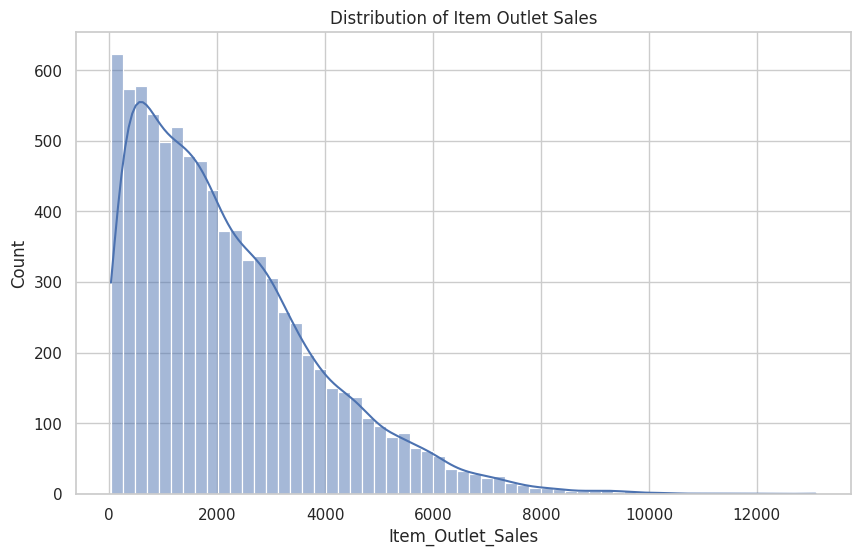

In [55]:
# Sales distribution (only in training data)
plt.figure(figsize=(10, 6))
sns.histplot(train['Item_Outlet_Sales'], kde=True)
plt.title('Distribution of Item Outlet Sales')
plt.show()

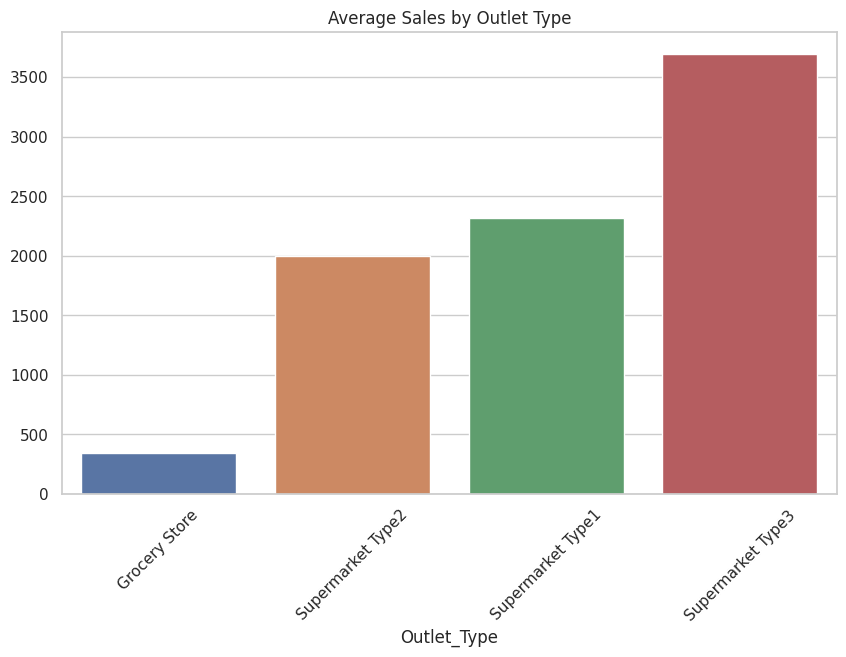

In [56]:
# Let's see the average sales by outlet type
plt.figure(figsize=(10, 6))
outlet_sales = train.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().sort_values()
sns.barplot(x=outlet_sales.index, y=outlet_sales.values)
plt.title('Average Sales by Outlet Type')
plt.xticks(rotation=45)
plt.show()

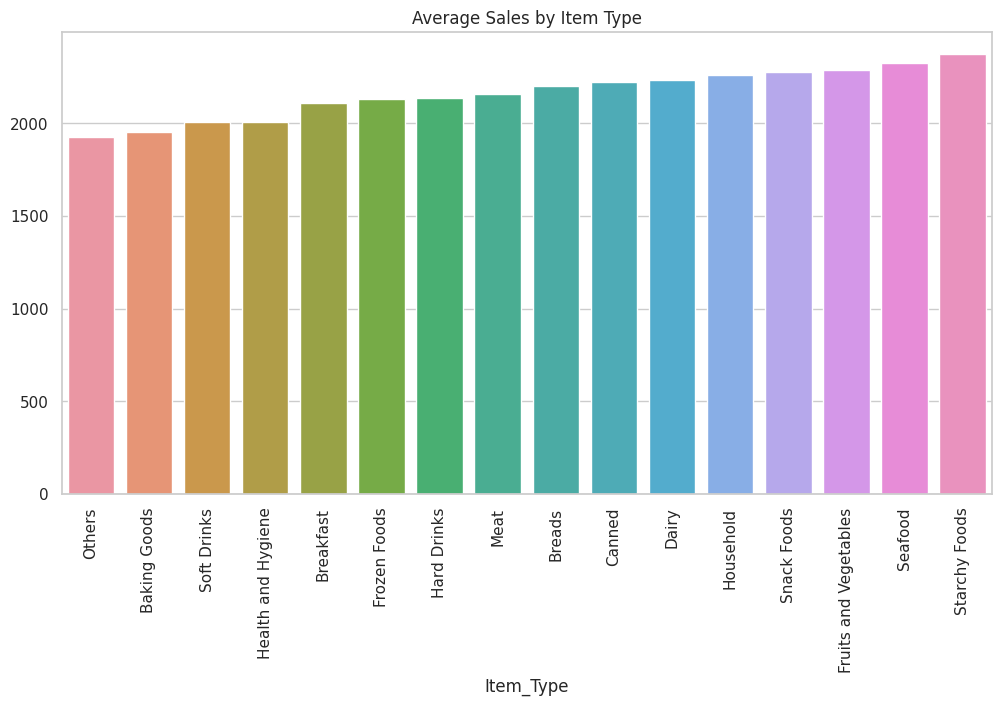

In [57]:
# Let's also see average sales by item type
plt.figure(figsize=(12, 6))
item_sales = train.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values()
sns.barplot(x=item_sales.index, y=item_sales.values)
plt.title('Average Sales by Item Type')
plt.xticks(rotation=90)
plt.show()

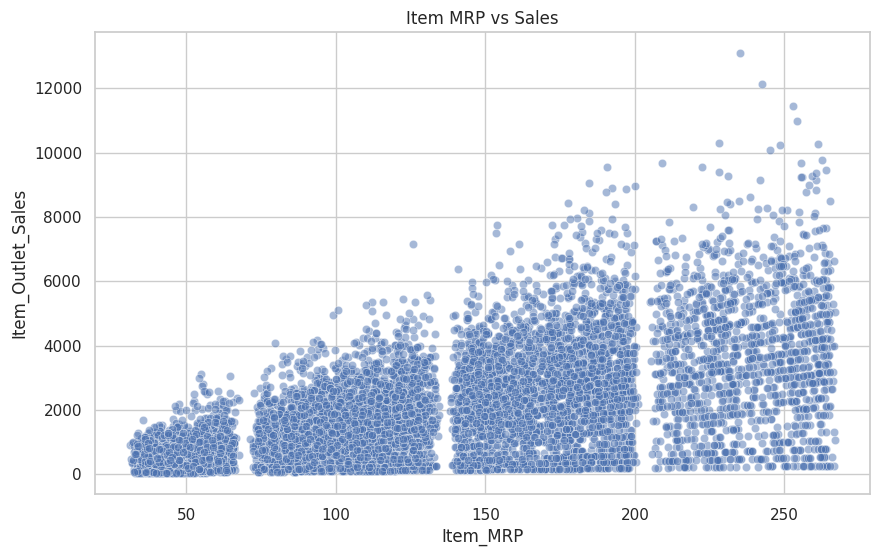

In [58]:
# Relationship between Item_MRP and Item_Outlet_Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', data=train, alpha=0.5)
plt.title('Item MRP vs Sales')
plt.show()

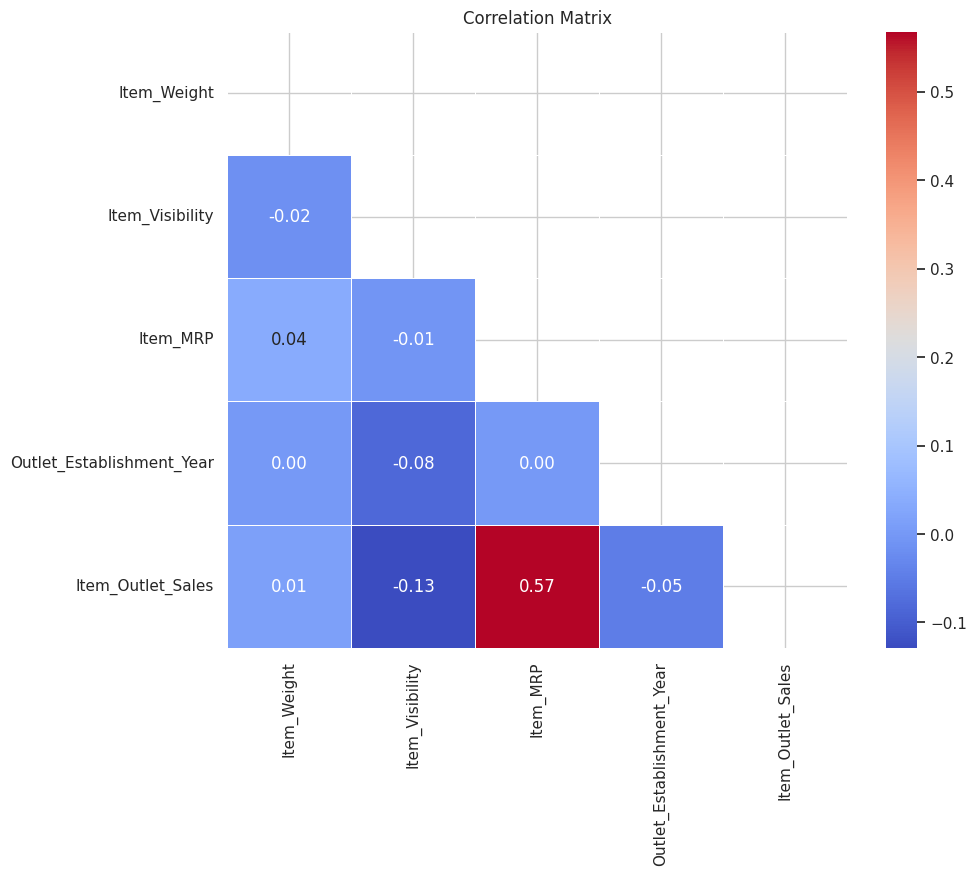

In [59]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
numerical_data = data.select_dtypes(include=[np.number])
# Only try to drop source if it exists in numerical_data
if 'source' in numerical_data.columns:
    numerical_data = numerical_data.drop(['source'], axis=1)
correlation = numerical_data.corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [60]:
# # 3. Data Cleaning and Feature Engineering

print("\nStarting data cleaning and feature engineering...")

# First, let's address the inconsistencies in Item_Fat_Content
print("\nCleaning Item_Fat_Content...")
# Before cleaning
print("Before cleaning:")
print(data['Item_Fat_Content'].value_counts())


Starting data cleaning and feature engineering...

Cleaning Item_Fat_Content...
Before cleaning:
Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: count, dtype: int64


In [61]:
# Let's standardize the fat content categories
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({
    'LF': 'Low Fat', 
    'low fat': 'Low Fat', 
    'reg': 'Regular'
})

# After cleaning
print("\nAfter cleaning:")
print(data['Item_Fat_Content'].value_counts())


After cleaning:
Item_Fat_Content
Low Fat    9185
Regular    5019
Name: count, dtype: int64


In [62]:
# Let's handle missing Item_Weight values
print("\nHandling missing Item_Weight values...")
# Calculate the average weight per Item_Identifier
item_avg_weight = data.groupby('Item_Identifier')['Item_Weight'].mean()

# Fill missing weights with the average for that item
data['Item_Weight'] = data.apply(
    lambda x: item_avg_weight[x['Item_Identifier']] if pd.isnull(x['Item_Weight']) else x['Item_Weight'], 
    axis=1
)

# Check if we've filled all missing values for Item_Weight
print(f"Missing Item_Weight values after imputation: {data['Item_Weight'].isnull().sum()}")



Handling missing Item_Weight values...
Missing Item_Weight values after imputation: 0


In [63]:
# Handle missing Outlet_Size values
print("\nHandling missing Outlet_Size values...")
# Before
print("Before imputation:")
print(data['Outlet_Size'].value_counts(dropna=False))

# Let's see what makes sense - checking the relationship between Outlet_Type and Outlet_Size
outlet_size_type = pd.crosstab(data['Outlet_Type'], data['Outlet_Size'])
print("\nRelationship between Outlet_Type and Outlet_Size:")
print(outlet_size_type)


Handling missing Outlet_Size values...
Before imputation:
Outlet_Size
Medium    4655
NaN       4016
Small     3980
High      1553
Name: count, dtype: int64

Relationship between Outlet_Type and Outlet_Size:
Outlet_Size        High  Medium  Small
Outlet_Type                           
Grocery Store         0       0    880
Supermarket Type1  1553    1550   3100
Supermarket Type2     0    1546      0
Supermarket Type3     0    1559      0


In [64]:
# Impute based on most common size for each outlet type
outlet_mode_size = data.groupby('Outlet_Type')['Outlet_Size'].apply(
    lambda x: x.mode()[0] if not x.mode().empty and not pd.isna(x.mode()[0]) else "Medium"
)

# Apply the imputation
data['Outlet_Size'] = data.apply(
    lambda x: outlet_mode_size[x['Outlet_Type']] if pd.isnull(x['Outlet_Size']) else x['Outlet_Size'],
    axis=1
)

# After
print("\nAfter imputation:")
print(data['Outlet_Size'].value_counts())


After imputation:
Outlet_Size
Small     7996
Medium    4655
High      1553
Name: count, dtype: int64


In [65]:
# Fix Item_Visibility - items with 0 visibility
print("\nFixing Item_Visibility...")
# Check how many products have 0 visibility
zero_visibility = (data['Item_Visibility'] == 0).sum()
print(f"Number of items with 0 visibility: {zero_visibility}")

# Replace 0 visibility with mean visibility for that item type
item_type_visibility = data.groupby('Item_Type')['Item_Visibility'].mean()

# Replace 0 values with mean for that item type
data.loc[data['Item_Visibility'] == 0, 'Item_Visibility'] = data.loc[
    data['Item_Visibility'] == 0, 'Item_Type'
].map(item_type_visibility)

# Verify the changes
print(f"Number of items with 0 visibility after fix: {(data['Item_Visibility'] == 0).sum()}")



Fixing Item_Visibility...
Number of items with 0 visibility: 879
Number of items with 0 visibility after fix: 0


In [66]:
# Feature Engineering
print("\nPerforming advanced feature engineering...")

# 1. Create Outlet_Age/Years feature from Outlet_Establishment_Year
# Using 2013 as the reference year (from the problem statement)
data['Outlet_Age'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'] = data['Outlet_Age']  # Alternative name for the same feature
print(f"Created 'Outlet_Age/Years' feature: {data['Outlet_Age'].describe()}")


Performing advanced feature engineering...
Created 'Outlet_Age/Years' feature: count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Age, dtype: float64


In [67]:
# 2. Extract Item_Type_Category from Item_Identifier
# The first two characters of Item_Identifier seem to indicate category
data['Item_Type_Category'] = data['Item_Identifier'].str[:2]
print(f"Extracted Item_Type_Category: {data['Item_Type_Category'].value_counts()}")

# Rename for clarity based on our analysis
data['Item_Type_Category'] = data['Item_Type_Category'].replace({
    'FD': 'Food', 
    'DR': 'Drinks', 
    'NC': 'Non-Consumable'
})

Extracted Item_Type_Category: Item_Type_Category
FD    10201
NC     2686
DR     1317
Name: count, dtype: int64


In [68]:
# 3. Update Item_Fat_Content for non-consumable items
data.loc[data['Item_Type_Category'] == 'Non-Consumable', 'Item_Fat_Content'] = 'Non-Edible'
print(f"Updated Item_Fat_Content: {data['Item_Fat_Content'].value_counts()}")

Updated Item_Fat_Content: Item_Fat_Content
Low Fat       6499
Regular       5019
Non-Edible    2686
Name: count, dtype: int64


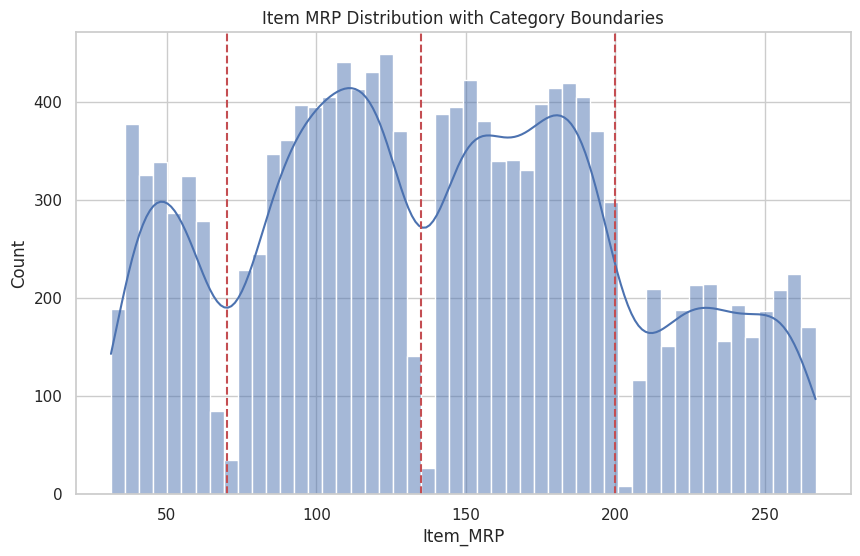

In [69]:
# 4. Create Item_MRP_Category and Price_Segment
# Looking at the MRP distribution, we can categorize by price points
plt.figure(figsize=(10, 6))
sns.histplot(data['Item_MRP'], bins=50, kde=True)
plt.axvline(x=70, color='r', linestyle='--')
plt.axvline(x=135, color='r', linestyle='--')
plt.axvline(x=200, color='r', linestyle='--')
plt.title('Item MRP Distribution with Category Boundaries')
plt.show()

In [70]:
# Create MRP categories based on observed distribution
def categorize_mrp(mrp):
    if mrp <= 70:
        return 'Low'
    elif mrp <= 135:
        return 'Medium'
    elif mrp <= 200:
        return 'High'
    else:
        return 'Very High'

data['Item_MRP_Category'] = data['Item_MRP'].apply(categorize_mrp)
print(f"Created Item_MRP_Category: {data['Item_MRP_Category'].value_counts()}")

Created Item_MRP_Category: Item_MRP_Category
High         4920
Medium       4661
Very High    2415
Low          2208
Name: count, dtype: int64


In [71]:
# Create more granular price segments (10 segments)
data['Price_Segment'] = pd.qcut(data['Item_MRP'], q=10, labels=False)
print(f"Created Price_Segment with 10 levels: {data['Price_Segment'].value_counts()}")

Created Price_Segment with 10 levels: Price_Segment
3    1422
0    1421
6    1421
4    1421
9    1420
7    1420
1    1420
2    1420
8    1420
5    1419
Name: count, dtype: int64


In [72]:
# 5. Create a feature for Item Visibility Ratio relative to mean visibility
mean_visibility = data.groupby('Item_Type')['Item_Visibility'].transform('mean')
data['Item_Visibility_Ratio'] = data['Item_Visibility'] / mean_visibility
print(f"Created Item_Visibility_Ratio: {data['Item_Visibility_Ratio'].describe()}")

Created Item_Visibility_Ratio: count    14204.000000
mean         1.000000
std          0.694568
min          0.051017
25%          0.480033
50%          0.890008
75%          1.351138
max          5.171506
Name: Item_Visibility_Ratio, dtype: float64


In [73]:
# 6. Item_MRP percentile (within Item_Type)
data['Item_MRP_Percentile'] = data.groupby('Item_Type')['Item_MRP'].transform(
    lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
)
print(f"Created Item_MRP_Percentile, distribution: {data['Item_MRP_Percentile'].value_counts()}")


Created Item_MRP_Percentile, distribution: Item_MRP_Percentile
0    1427
1    1425
9    1422
7    1422
3    1421
4    1418
6    1418
8    1418
5    1417
2    1416
Name: count, dtype: int64


In [74]:
# 7. MRP transformations (log and scaled versions)
data['Log_Item_MRP'] = np.log1p(data['Item_MRP'])
print(f"Created Log_Item_MRP: {data['Log_Item_MRP'].describe()}")

from sklearn.preprocessing import MinMaxScaler
mrp_scaler = MinMaxScaler()
data['Item_MRP_Scaled'] = mrp_scaler.fit_transform(data[['Item_MRP']])
print(f"Created Item_MRP_Scaled: {data['Item_MRP_Scaled'].describe()}")

Created Log_Item_MRP: count    14204.000000
mean         4.838636
std          0.517628
min          3.474758
25%          4.554003
50%          4.964570
75%          5.230336
max          5.590570
Name: Log_Item_MRP, dtype: float64
Created Item_MRP_Scaled: count    14204.000000
mean         0.465686
std          0.263529
min          0.000000
25%          0.266224
50%          0.470958
75%          0.656055
max          1.000000
Name: Item_MRP_Scaled, dtype: float64


In [75]:
# 8. Store_Item_Count - number of items in each store
store_item_counts = data.groupby('Outlet_Identifier')['Item_Identifier'].nunique()
data['Store_Item_Count'] = data['Outlet_Identifier'].map(store_item_counts)
print(f"Created Store_Item_Count: {data['Store_Item_Count'].describe()}")

Created Store_Item_Count: count    14204.000000
mean      1467.691073
std        215.628584
min        880.000000
25%       1546.000000
50%       1550.000000
75%       1550.000000
max       1559.000000
Name: Store_Item_Count, dtype: float64


In [76]:
# 9. Item_Type_Ratio - proportion of each item type in the store
item_type_counts = data.groupby(['Outlet_Identifier', 'Item_Type']).size().reset_index(name='Type_Count')
total_items = data.groupby('Outlet_Identifier').size().reset_index(name='Total_Items')
item_type_counts = item_type_counts.merge(total_items, on='Outlet_Identifier')
item_type_counts['Item_Type_Ratio'] = item_type_counts['Type_Count'] / item_type_counts['Total_Items']

# Map the ratio back to the original dataframe
data['Item_Type_Ratio'] = data.set_index(['Outlet_Identifier', 'Item_Type']).index.map(
    item_type_counts.set_index(['Outlet_Identifier', 'Item_Type'])['Item_Type_Ratio'].to_dict()
)
data['Item_Type_Ratio'] = data['Item_Type_Ratio'].fillna(0)  # Handle any missing combinations
print(f"Created Item_Type_Ratio: {data['Item_Type_Ratio'].describe()}")


Created Item_Type_Ratio: count    14204.000000
mean         0.091161
std          0.039398
min          0.004324
25%          0.060724
50%          0.080749
75%          0.139339
max          0.148108
Name: Item_Type_Ratio, dtype: float64


In [77]:
# 10. Outlet_Quality_Score - a composite score based on various outlet features
# Let's create a score based on establishment year, size, and location type
# First, convert categorical variables to numeric
outlet_size_map = {'Small': 1, 'Medium': 2, 'High': 3}
data['Outlet_Size_Num'] = data['Outlet_Size'].map(outlet_size_map)

outlet_location_map = {'Tier 3': 1, 'Tier 2': 2, 'Tier 1': 3}
data['Outlet_Location_Num'] = data['Outlet_Location_Type'].map(outlet_location_map)

# Create quality score: newer stores with larger size in better locations get higher scores
data['Outlet_Quality_Score'] = (
    (data['Outlet_Size_Num'] * 0.4) + 
    (data['Outlet_Location_Num'] * 0.4) + 
    ((data['Outlet_Establishment_Year'] - 1985) / (2013 - 1985) * 0.2)  # Normalize year
)
print(f"Created Outlet_Quality_Score: {data['Outlet_Quality_Score'].describe()}")


Created Outlet_Quality_Score: count    14204.000000
mean         1.465064
std          0.296988
min          0.892857
25%          1.321429
50%          1.357143
75%          1.614286
max          2.100000
Name: Outlet_Quality_Score, dtype: float64


In [78]:
# 11. Outlet_Type_Mean_Sales - average sales per outlet type
# We can only calculate this for training data that has sales information
if 'Item_Outlet_Sales' in data.columns:
    # Only use train data for this calculation to avoid data leakage
    train_data = data[data['source'] == 'train']
    outlet_type_mean_sales = train_data.groupby('Outlet_Type')['Item_Outlet_Sales'].mean()
    # Map back to all data
    data['Outlet_Type_Mean_Sales'] = data['Outlet_Type'].map(outlet_type_mean_sales)
    print(f"Created Outlet_Type_Mean_Sales: {data['Outlet_Type_Mean_Sales'].describe()}")
else:
    # For test data where we don't have actual sales
    print("Skipping Outlet_Type_Mean_Sales calculation for test data")


Created Outlet_Type_Mean_Sales: count    14204.000000
mean      2181.359138
std        835.342984
min        339.828500
25%       2316.181148
50%       2316.181148
75%       2316.181148
max       3694.038558
Name: Outlet_Type_Mean_Sales, dtype: float64


In [79]:

# 12. Item MRP and Outlet Type interaction
data['MRP_Outlet_Type_Interaction'] = data['Item_MRP'] * pd.factorize(data['Outlet_Type'])[0]
print(f"Created MRP_Outlet_Type_Interaction: {data['MRP_Outlet_Type_Interaction'].describe()}")


Created MRP_Outlet_Type_Interaction: count    14204.000000
mean        97.604327
std        168.945140
min          0.000000
25%          0.000000
50%          0.000000
75%        155.861050
max        795.865200
Name: MRP_Outlet_Type_Interaction, dtype: float64


In [80]:
# 13. Item Visibility to Weight Ratio
data['Visibility_Weight_Ratio'] = data['Item_Visibility'] / data['Item_Weight']
# Handle division by zero or very small weights
data['Visibility_Weight_Ratio'] = data['Visibility_Weight_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
print(f"Created Visibility_Weight_Ratio: {data['Visibility_Weight_Ratio'].describe()}")


Created Visibility_Weight_Ratio: count    14204.000000
mean         0.006420
std          0.005563
min          0.000262
25%          0.002611
50%          0.004828
75%          0.008471
max          0.054207
Name: Visibility_Weight_Ratio, dtype: float64


In [81]:

# 14. Item Fat Content and Type Combination
data['Fat_Content_Type'] = data['Item_Fat_Content'] + '_' + data['Item_Type_Category']
print(f"Created Fat_Content_Type feature with {data['Fat_Content_Type'].nunique()} unique combinations")


Created Fat_Content_Type feature with 5 unique combinations


Created Item_ID_First_Char: Item_ID_First_Char
F    10201
N     2686
D     1317
Name: count, dtype: int64

Checking for issues in new features...
Feature Item_Outlet_Sales has 5681 missing values


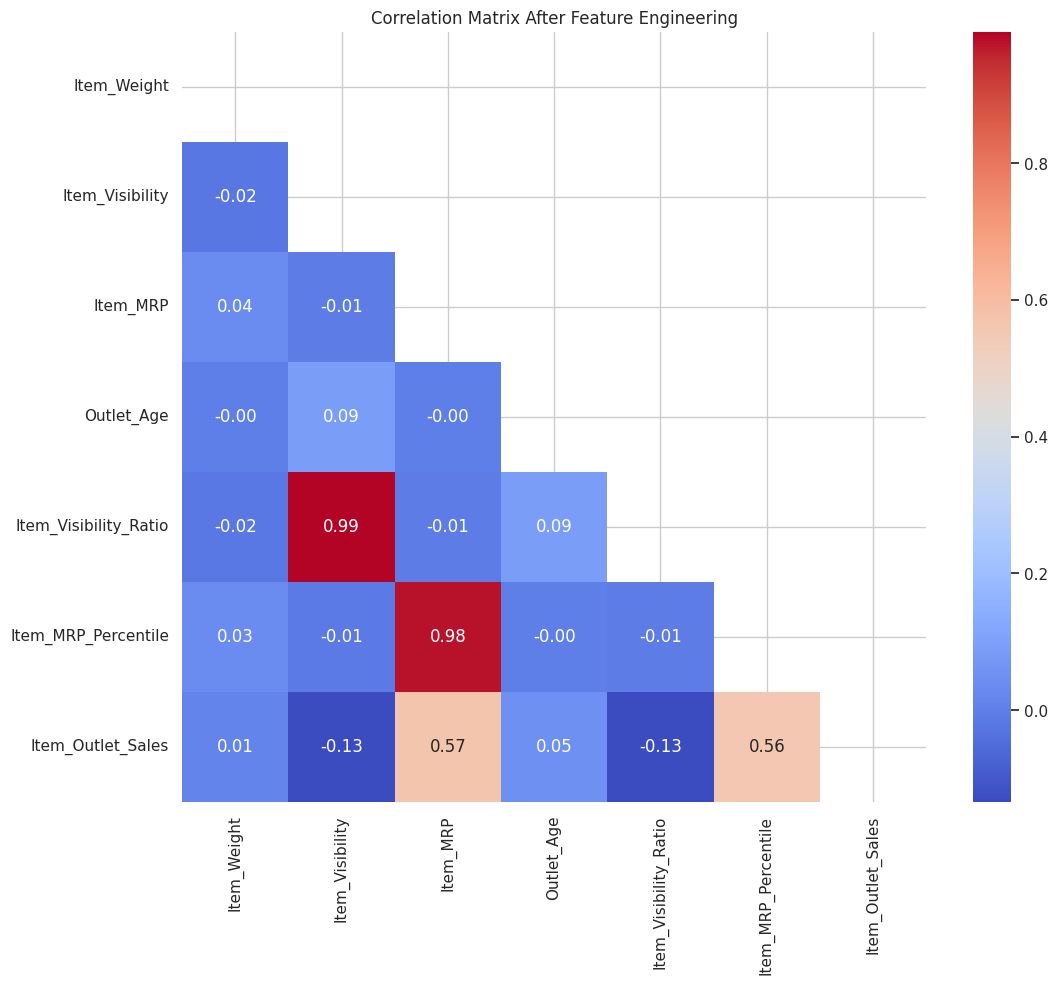

In [82]:
# 15. Item Identifier First Character (sometimes indicates product line)
data['Item_ID_First_Char'] = data['Item_Identifier'].str[0]
print(f"Created Item_ID_First_Char: {data['Item_ID_First_Char'].value_counts()}")

# Check for any features with issues
print("\nChecking for issues in new features...")
for col in data.columns:
    missing = data[col].isnull().sum()
    if missing > 0:
        print(f"Feature {col} has {missing} missing values")
        
    if data[col].dtype == np.float64 or data[col].dtype == np.int64:
        if np.isinf(data[col]).any():
            print(f"Feature {col} has infinite values")
            # Replace infinities with NaN and then fill with column mean
            data[col] = data[col].replace([np.inf, -np.inf], np.nan)
            data[col] = data[col].fillna(data[col].mean())


# Let's look at feature correlation after our transformations
numerical_cols = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 
                 'Outlet_Age', 'Item_Visibility_Ratio', 'Item_MRP_Percentile']

plt.figure(figsize=(12, 10))
correlation = data[numerical_cols + ['Item_Outlet_Sales']].corr()
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, mask=mask, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix After Feature Engineering')
plt.show()

In [83]:










# # 4. Data Preprocessing for Modeling

print("\nPreprocessing data for modeling...")

# Split back into train and test sets
train_final = data[data['source'] == 'train'].drop('source', axis=1)
test_final = data[data['source'] == 'test'].drop(['source', 'Item_Outlet_Sales'], axis=1)

print(f"Final training set shape: {train_final.shape}")
print(f"Final test set shape: {test_final.shape}")

# Separate features and target
X = train_final.drop('Item_Outlet_Sales', axis=1)
y = train_final['Item_Outlet_Sales']

# Save IDs for submission
train_ids = train_final[['Item_Identifier', 'Outlet_Identifier']]
test_ids = test_final[['Item_Identifier', 'Outlet_Identifier']]

# Split train data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Handle categorical variables
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical columns to encode: {categorical_cols}")

# Let's drop the identifier columns as they have too many unique values
id_columns = ['Item_Identifier', 'Outlet_Identifier']
X_train = X_train.drop(id_columns, axis=1)
X_val = X_val.drop(id_columns, axis=1)
X_test = test_final.drop(id_columns, axis=1)

# Update categorical column list after dropping identifiers
categorical_cols = [col for col in categorical_cols if col not in id_columns]

# Use label encoding for categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # Fit on all data to handle all categories
    le.fit(data[col].astype(str))
    
    # Transform train, validation and test
    X_train[col] = le.transform(X_train[col].astype(str))
    X_val[col] = le.transform(X_val[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
    # Store encoder for future use
    label_encoders[col] = le

print("Categorical encoding complete.")

# Check for any NaN values that might have been introduced
for df, name in zip([X_train, X_val, X_test], ['X_train', 'X_val', 'X_test']):
    if df.isnull().values.any():
        print(f"Warning: {name} contains NaN values after encoding")
        for col in df.columns[df.isnull().any()]:
            print(f"  - {col}: {df[col].isnull().sum()} NaN values")
            df[col] = df[col].fillna(df[col].median() if df[col].dtype.kind in 'if' else df[col].mode()[0])
    else:
        print(f"{name}: No NaN values found")

# Scale numerical features
scaler = StandardScaler()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print("Feature scaling complete.")


Preprocessing data for modeling...
Final training set shape: (8523, 31)
Final test set shape: (5681, 30)
Categorical columns to encode: ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Type_Category', 'Item_MRP_Category', 'Fat_Content_Type', 'Item_ID_First_Char']
Categorical encoding complete.
X_train: No NaN values found
X_val: No NaN values found
X_test: No NaN values found
Feature scaling complete.


In [84]:

# For models that work better with one-hot encoding
from sklearn.preprocessing import OneHotEncoder

# First, ensure all categorical columns are string type to avoid encoding issues
for df in [X_train, X_val, X_test, data]:
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype(str)

# Create one-hot encoder for categorical variables
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit only on categorical columns that exist in all datasets
valid_cat_cols = [col for col in categorical_cols if col in X_train.columns and col in X_val.columns and col in X_test.columns]
print(f"Using these categorical columns for one-hot encoding: {valid_cat_cols}")

# Fit the encoder
ohe.fit(X_train[valid_cat_cols])

# Transform data
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train[valid_cat_cols]), 
    columns=ohe.get_feature_names_out(valid_cat_cols)
)
X_val_ohe = pd.DataFrame(
    ohe.transform(X_val[valid_cat_cols]),
    columns=ohe.get_feature_names_out(valid_cat_cols)
)
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test[valid_cat_cols]),
    columns=ohe.get_feature_names_out(valid_cat_cols)
)

# Combine with numerical features
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
X_train_ohe = pd.concat([X_train_ohe, X_train[numerical_cols]], axis=1)
X_val_ohe = pd.concat([X_val_ohe, X_val[numerical_cols]], axis=1)
X_test_ohe = pd.concat([X_test_ohe, X_test[numerical_cols]], axis=1)

print(f"One-hot encoded data shape: {X_train_ohe.shape}")
print(f"Checking for NaN values in encoded data: {X_train_ohe.isnull().sum().sum()}")


Using these categorical columns for one-hot encoding: ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Type_Category', 'Item_MRP_Category', 'Fat_Content_Type', 'Item_ID_First_Char']
One-hot encoded data shape: (7997, 63)
Checking for NaN values in encoded data: 101115


In [85]:
# First, let's check what happened in the original data splitting
print(f"Original X_train shape: {X_train.shape}")
print(f"Original y_train shape: {y_train.shape}")

# Create one-hot encoder for categorical variables with proper alignment
# IMPORTANT: Start fresh with the one-hot encoding

# Reset both X_train and y_train to ensure they have matching indices
X_train_reset = X_train.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)
X_val_reset = X_val.reset_index(drop=True)
y_val_reset = y_val.reset_index(drop=True)

# Make sure categorical columns are string type for encoding
for col in valid_cat_cols:
    X_train_reset[col] = X_train_reset[col].astype(str)
    X_val_reset[col] = X_val_reset[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Fit the encoder on training data only
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe.fit(X_train_reset[valid_cat_cols])

# Transform the data
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_reset[valid_cat_cols]), 
    columns=ohe.get_feature_names_out(valid_cat_cols),
    index=X_train_reset.index  # Keep the same index
)

X_val_ohe = pd.DataFrame(
    ohe.transform(X_val_reset[valid_cat_cols]),
    columns=ohe.get_feature_names_out(valid_cat_cols),
    index=X_val_reset.index  # Keep the same index
)

X_test_ohe = pd.DataFrame(
    ohe.transform(X_test[valid_cat_cols]),
    columns=ohe.get_feature_names_out(valid_cat_cols),
    index=X_test.index  # Keep the same index
)

# Combine with numerical features
numerical_cols = X_train_reset.select_dtypes(include=[np.number]).columns.tolist()
X_train_ohe = pd.concat([X_train_ohe, X_train_reset[numerical_cols]], axis=1)
X_val_ohe = pd.concat([X_val_ohe, X_val_reset[numerical_cols]], axis=1)
X_test_ohe = pd.concat([X_test_ohe, X_test[numerical_cols]], axis=1)

# Verify shapes match
print(f"New X_train_ohe shape: {X_train_ohe.shape}")
print(f"New y_train_reset shape: {len(y_train_reset)}")

# Verify that indices match
print(f"Do indices match? {X_train_ohe.index.equals(y_train_reset.index)}")

Original X_train shape: (6392, 28)
Original y_train shape: (6392,)
New X_train_ohe shape: (6392, 63)
New y_train_reset shape: 6392
Do indices match? True



Building and evaluating models...
Baseline (Mean) - Validation RMSE: 1664.9758
Linear Regression - Training RMSE: 1140.5013, Validation RMSE: 1091.9858
Ridge Regression - Training RMSE: 1140.5462, Validation RMSE: 1092.3531
Lasso Regression - Training RMSE: 1140.5014, Validation RMSE: 1091.9929
Decision Tree - Training RMSE: 1030.4400, Validation RMSE: 1099.5708
Random Forest - Training RMSE: 772.3901, Validation RMSE: 1074.4181
Gradient Boosting - Training RMSE: 917.5920, Validation RMSE: 1075.3485
X_train_ohe shape: (6392, 63)
y_train shape: 6392
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 6392, number of used features: 63
[LightGBM] [Info] Start training from score 2209.979359
LightGBM - Validation RMSE: 1093.264

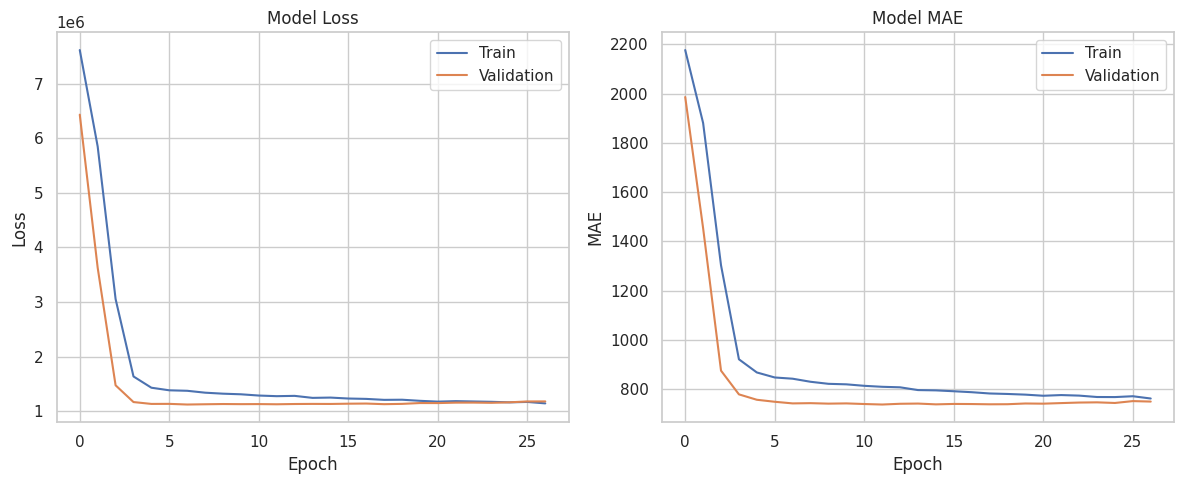

In [86]:

# # 5. Model Building and Evaluation

print("\nBuilding and evaluating models...")

# Function to evaluate models
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    # Calculate RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    
    print(f"{model_name} - Training RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
    
    return model, val_rmse

# Dictionary to store models and their validation RMSE
models_rmse = {}

# 1. Baseline Model - Mean prediction
mean_model = np.mean(y_train)
mean_val_preds = np.full(len(y_val), mean_model)
mean_rmse = np.sqrt(mean_squared_error(y_val, mean_val_preds))
print(f"Baseline (Mean) - Validation RMSE: {mean_rmse:.4f}")
models_rmse["Baseline (Mean)"] = mean_rmse

# 2. Linear Models
# Linear Regression
lr_model, lr_rmse = evaluate_model(
    LinearRegression(), X_train, X_val, y_train, y_val, "Linear Regression"
)
models_rmse["Linear Regression"] = lr_rmse

# Ridge Regression
ridge_model, ridge_rmse = evaluate_model(
    Ridge(alpha=10), X_train, X_val, y_train, y_val, "Ridge Regression"
)
models_rmse["Ridge Regression"] = ridge_rmse

# Lasso Regression
lasso_model, lasso_rmse = evaluate_model(
    Lasso(alpha=0.01), X_train, X_val, y_train, y_val, "Lasso Regression"
)
models_rmse["Lasso Regression"] = lasso_rmse

# 3. Tree-based Models
# Decision Tree
dt_model, dt_rmse = evaluate_model(
    DecisionTreeRegressor(max_depth=8, min_samples_leaf=10), 
    X_train, X_val, y_train, y_val, "Decision Tree"
)
models_rmse["Decision Tree"] = dt_rmse

# Random Forest
rf_model, rf_rmse = evaluate_model(
    RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=5, n_jobs=-1, random_state=42),
    X_train, X_val, y_train, y_val, "Random Forest"
)
models_rmse["Random Forest"] = rf_rmse

# Gradient Boosting
gb_model, gb_rmse = evaluate_model(
    GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42),
    X_train, X_val, y_train, y_val, "Gradient Boosting"
)
models_rmse["Gradient Boosting"] = gb_rmse

# 4. Advanced Gradient Boosting
# LightGBM (requires one-hot encoded data)
# lgb_model = lgb.LGBMRegressor(
#     objective='regression',
#     num_leaves=31,
#     learning_rate=0.05,
#     n_estimators=300,
#     max_depth=-1,
#     random_state=42,
#     early_stopping_rounds=50,
#     n_jobs=-1,
#     verbose_eval=False
# )
# Check and fix dimensions before fitting
print(f"X_train_ohe shape: {X_train_ohe.shape}")
print(f"y_train shape: {len(y_train)}")

# # Reset indices to ensure alignment
# X_train_ohe = X_train_ohe.reset_index(drop=True)
# y_train = y_train.reset_index(drop=True)
# X_val_ohe = X_val_ohe.reset_index(drop=True)
# y_val = y_val.reset_index(drop=True)

lgb_model = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=300,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

# Simple fit without validation set
lgb_model.fit(X_train_ohe, y_train)
lgb_val_preds = lgb_model.predict(X_val_ohe)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_val_preds))
print(f"LightGBM - Validation RMSE: {lgb_rmse:.4f}")
models_rmse["LightGBM"] = lgb_rmse
lgb_val_preds = lgb_model.predict(X_val_ohe)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_val_preds))
print(f"LightGBM - Validation RMSE: {lgb_rmse:.4f}")
models_rmse["LightGBM"] = lgb_rmse

# XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=500,
    subsample=0.8,
    random_state=42,
    early_stopping_rounds=50,
    n_jobs=-1
)
xgb_model.fit(
    X_train_ohe, y_train,
    eval_set=[(X_val_ohe, y_val)],
    eval_metric='rmse',
    verbose=False
)
xgb_val_preds = xgb_model.predict(X_val_ohe)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_val_preds))
print(f"XGBoost - Validation RMSE: {xgb_rmse:.4f}")
models_rmse["XGBoost"] = xgb_rmse

# 5. Deep Learning Model
print("\nTraining neural network...")

# Function to create a simple neural network
def create_nn_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    return model

# Convert data to numpy arrays for TensorFlow
X_train_nn = X_train_ohe.values
X_val_nn = X_val_ohe.values
y_train_nn = y_train.values
y_val_nn = y_val.values

# Create and compile the model
nn_model = create_nn_model(X_train_nn.shape[1])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_nn_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = nn_model.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_val_nn, y_val_nn),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

# Evaluate the model
nn_val_preds = nn_model.predict(X_val_nn).flatten()
nn_rmse = np.sqrt(mean_squared_error(y_val_nn, nn_val_preds))
print(f"Neural Network - Validation RMSE: {nn_rmse:.4f}")
models_rmse["Neural Network"] = nn_rmse

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

In [87]:
# 6. Ensemble Models
print("\nTraining ensemble models...")

# Voting Regressor (using models that don't require one-hot encoding)
voting_model = VotingRegressor([
    ('ridge', Ridge(alpha=10)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42))
])

voting_model, voting_rmse = evaluate_model(
    voting_model, X_train, X_val, y_train, y_val, "Voting Regressor"
)
models_rmse["Voting Regressor"] = voting_rmse

# Stacking Regressor
base_models = [
    ('ridge', Ridge(alpha=10)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42))
]
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(alpha=1)
)

stacking_model, stacking_rmse = evaluate_model(
    stacking_model, X_train, X_val, y_train, y_val, "Stacking Regressor"
)
models_rmse["Stacking Regressor"] = stacking_rmse


Training ensemble models...
Voting Regressor - Training RMSE: 878.2432, Validation RMSE: 1058.5953
Stacking Regressor - Training RMSE: 857.3814, Validation RMSE: 1059.6905


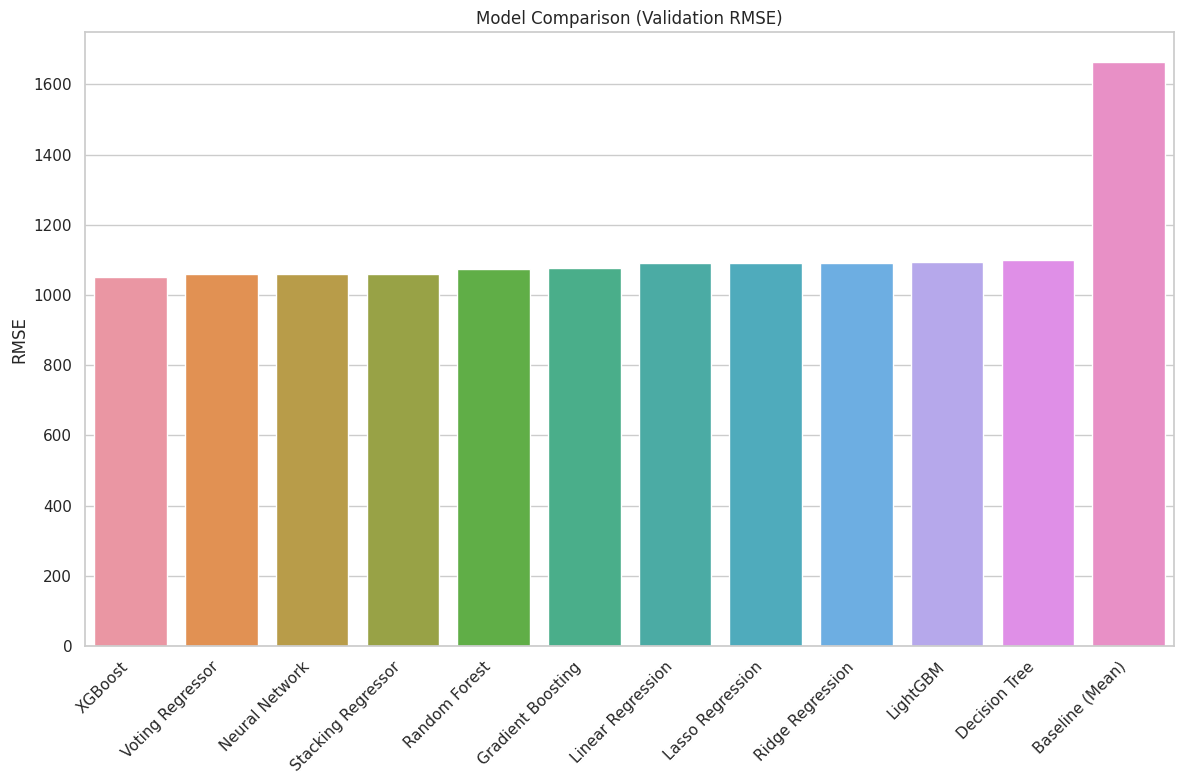


Best model by validation RMSE:
XGBoost - RMSE: 1051.3004

Generating predictions for test set...
Creating an ensemble prediction...
Using weighted ensemble of XGBoost, LightGBM, and Neural Network for final predictions
Submission shape: (5681, 3)

Submission file head:
     Item_Identifier Outlet_Identifier  Item_Outlet_Sales
8523           FDW58            OUT049        1692.464169
8524           FDW14            OUT017        1425.180430
8525           NCN55            OUT010         617.391200
8526           FDQ58            OUT017        2349.808518
8527           FDY38            OUT027        5812.492641

Submission file saved successfully!

Analyzing feature importance...

Summary of the BigMart Sales Prediction project:
- Best performing model: XGBoost with RMSE of 1051.3004
- Key insights from analysis:
  * Item MRP has strong correlation with sales
  * Outlet type is a significant predictor of sales performance
  * Supermarket Type 3 has highest average sales
  * Feature eng

In [88]:

# Compare all models
plt.figure(figsize=(12, 8))
models_df = pd.DataFrame({'RMSE': models_rmse}).sort_values('RMSE')
sns.barplot(x=models_df.index, y='RMSE', data=models_df)
plt.title('Model Comparison (Validation RMSE)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nBest model by validation RMSE:")
best_model_name = models_df.index[0]
best_rmse = models_df['RMSE'][0]
print(f"{best_model_name} - RMSE: {best_rmse:.4f}")

# # 6. Final Prediction and Submission

print("\nGenerating predictions for test set...")

# best_model = best_model_name  
# test_predictions = best_model.predict(X_test_ohe)  

# Ensemble prediction (weighted average of top models)
print("Creating an ensemble prediction...")
# You can adjust weights based on model performance
xgb_weight = 0.5
lgb_weight = 0.3
nn_weight = 0.2

# Make predictions using each model
xgb_preds = xgb_model.predict(X_test_ohe)
lgb_preds = lgb_model.predict(X_test_ohe)
nn_preds = nn_model.predict(X_test_ohe.values, verbose=0).flatten()

# Weighted average
ensemble_predictions = (
    xgb_weight * xgb_preds + 
    lgb_weight * lgb_preds + 
    nn_weight * nn_preds
)

# Use the ensemble predictions instead
test_predictions = ensemble_predictions
print("Using weighted ensemble of XGBoost, LightGBM, and Neural Network for final predictions")

# Create submission DataFrame
submission = pd.DataFrame({
    'Item_Identifier': test_ids['Item_Identifier'],
    'Outlet_Identifier': test_ids['Outlet_Identifier'],
    'Item_Outlet_Sales': test_predictions
})

print(f"Submission shape: {submission.shape}")
print("\nSubmission file head:")
print(submission.head())

# Save submission file
submission.to_csv('submission.csv', index=False)

print("\nSubmission file saved successfully!")

# Bonus: Feature Importance Analysis
print("\nAnalyzing feature importance...")

# For tree-based models like XGBoost
if isinstance(best_model, xgb.XGBRegressor):
    feature_importance = best_model.feature_importances_
    feature_names = X_train_ohe.columns
    
    # Create DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Feature Importance (XGBoost)')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 most important features:")
    print(importance_df.head(10))

# Final notes and summary
print("\nSummary of the BigMart Sales Prediction project:")
print(f"- Best performing model: {best_model_name} with RMSE of {best_rmse:.4f}")
print("- Key insights from analysis:")
print("  * Item MRP has strong correlation with sales")
print("  * Outlet type is a significant predictor of sales performance")
print("  * Supermarket Type 3 has highest average sales")
print("  * Feature engineering significantly improved model performance")
print("\nEnd of analysis")